In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
Umlip_dict = {
    "0": "0-GRACE-2L-OMAT",
    "1": "1-GRACE-2L-OAM",
    "2": "2-eqV2-31",
    "3": "3-eqV2-86",
    "4": "4-eqV2-153",
    "5": "5-DPA3-v1",
    "6": "6-DPA3-V2",
    "7": "7-7net",
    "8": "8-esen",
    "9": "9-MACE-omat",
    "10": "10-eqV2-31-omat",
    "11": "11-eqV2-86-omat",
    "12": "12-eqV2-153-omat",
    "13": "13-esen-omat",
    "14": "14-orb-omat-c-inf-conf",
    "15": "15-orb-omat-20",
    "16": "16-orb-omat-d-inf",
    "17": "17-orb-omat-d-20",
    "18": "18-7net-omat",
    "19": "19-7net-omat-2",
    "20": "20-MACE-mpa"
}

In [3]:
Umlip_list = [13,10,11,19,18,7,9,15,14,17,16,2,3,8,0,1,6,5] # here uMLIPs are sorted in the ascending RMSE of Force

Force_RMSE = [0.23719, 0.243286, 0.24351, 0.253712, 0.2643,
              0.27751, 0.350226, 0.48766, 0.49757, 0.50635, 0.5111, 0.779,
              0.81703, 1.0775, 1.384136, 1.5914649, 2.46236, 6.22137]

TopN = 11
Umlip_used = Umlip_list[:TopN]
Force_RMSE_used = Force_RMSE[:TopN]

reciprocal = 1 / np.array(Force_RMSE_used)
force_weight = reciprocal / np.sum(reciprocal)

In [4]:
force_weight

array([0.12181988, 0.11876745, 0.1186582 , 0.11388684, 0.10932447,
       0.10412042, 0.08250232, 0.05925123, 0.05807114, 0.0570642 ,
       0.05653386])

In [21]:
df_dft = pd.read_pickle(f"./W_DFT.pckl.gzip", compression="gzip")
df_dft["energy_peratom"] = df_dft.apply(lambda row: row["energy"] / 
                                            row["ase_atoms"].get_global_number_of_atoms(), axis=1)
for n in Umlip_list:
    globals()[f'df_umlip_{n}'] = pd.read_pickle(f"./W_uMLIP/{Umlip_dict[str(n)]}.pckl.gzip",compression='gzip')
    
    

In [7]:
df_umlip_13.head()

,ase_atoms,energy,forces,energy_corrected
0,"(Atom('W', [2.76639, 4.46897, 0.76164], index=...",-12.375169,"[[-0.6800152, -0.63384926, 0.33527553], [0.882...",-12.375169
1,"(Atom('W', [0.0, 0.0, 0.0], index=0), Atom('W'...",-12.780429,"[[6.172224e-06, -3.2904354e-06, -3.0814263e-06...",-12.780429
2,"(Atom('W', [1.58716, 3.07787, 1.64456], index=...",-12.363012,"[[0.0921689, -0.5703832, -0.8758351], [0.02235...",-12.363012
3,"(Atom('W', [0.0, 0.0, 0.0], index=0), Atom('W'...",-12.861565,"[[-6.270595e-06, -6.55395e-06, -1.1825701e-05]...",-12.861565
4,"(Atom('W', [4.51001, 3.16307, 7.64847], index=...",-12.441711,"[[-0.08991341, -0.06412814, -0.10508734], [0.0...",-12.441711


In [8]:
UQ = pd.DataFrame(index=df_dft.index, columns=["N_atoms","Elements","Type","Energy_mean", "Energy_std",
                                                       "Energy_error","Energy_error_list",
                                                       "Force_mean", "Force_max_dev_max","Force_max_dev_list",
                                                       "Force_mean_dev_list","Force_error","Force_error_max","Uncertainty U"])
    # "N_atoms": Number of atoms,"Elements": symbols for elements, "Type": Metal or X, 
    # "Energy_mean": mean of energies predicted by umlips. "Energy_std"
    # "Energy_error": energy_dft - energy_umlip_mean
    # "Energy_error_list": list of (energy_dft - energy_umlip) for each umlip
    # "Force_mean": mean of force prediction, d1: atom  d2: x,y,z
    # "Force_UQ_max": max deviation vector length for all umlips, one value
    # "Force_max_dev_list": max deviation vector length for each umlip, a list
    # "Force_mean_dev_list": mean deviation vector length for each umlip, a list
    # "Force_error": force_dft - force_umlip_mean
    # "Force_error_max": max deviation vector length for mean_umlip w.r.t force_dft
Current_index = df_dft.index

for j in Current_index:
    force_list = []
    umlip_energies = []
    Elements = df_dft.loc[j, "ase_atoms"].get_chemical_symbols()
    symbols = set(Elements)
    UQ.loc[j, 'N_atoms'] = len(Elements)
    UQ.loc[j, 'Elements'] = symbols
    # Check if all are metals, non-metals, or mixed
    for k in Umlip_used:  
        df = globals()[f"df_umlip_{k}"]  # Access DataFrame by name
        force_list.append(df.loc[j, "forces"])  # N×3 matrix
        umlip_energies.append(df.loc[j, "energy_corrected"])

    Force_e = np.dstack(force_list)  # Stack into 3D array  d1: atom d2: x,y,z d3:umlip

    # use simple averaged value as mean value
    averaged_f = np.mean(Force_e, axis=2)  # Mean along third axis


    UQ.at[j, "Force_mean"] = averaged_f.tolist()
    Force_shift = Force_e - averaged_f[:, :, np.newaxis]


    distances = np.sqrt(np.sum(Force_shift**2, axis=1))
    max_error = np.max(distances)
    max_error_umlip = np.max(distances,axis = 0)
    mean_error_umlip = np.mean(distances,axis = 0)
    UQ.at[j, "Force_max_dev_max"] = max_error
    UQ.at[j, "Force_max_dev_list"] = max_error_umlip.tolist()
    UQ.at[j, "Force_mean_dev_list"] = mean_error_umlip.tolist()

    Force_error = df_dft["forces"].loc[j] - averaged_f
    UQ.at[j, "Force_error"] = Force_error
    error_length = np.sqrt(np.sum(Force_error**2, axis=1))
    Force_error_max = np.max(abs(error_length))
    UQ.at[j, "Force_error_max"] = Force_error_max

    mean_val = np.mean(umlip_energies)
    Energy_error_list = umlip_energies - mean_val
    UQ.at[j, "Energy_error_list"] = Energy_error_list.tolist()
    std_val = np.std(umlip_energies)
    UQ.at[j, "Energy_mean"] = mean_val
    UQ.at[j, "Energy_std"] = std_val
    dft_energy = df_dft.loc[j, "energy_peratom"]
    error =  np.abs(dft_energy - mean_val)
    UQ.at[j, "Energy_error"] = error
    
#     for k in Use_umlip_energy:  
#         df = globals()[f"df_umlip_{k}"]  # Access DataFrame by name
#         umlip_energies.append(df.loc[j, "energy_corrected"])
    mean_val = np.mean(umlip_energies)
    UQ.at[j, "Energy_mean_oam"] = mean_val
    dft_energy = df_dft.loc[j, "energy_peratom"]
    error =  np.abs(dft_energy - mean_val)
    UQ.at[j, "Energy_error_oam"] = error
#    UQ = UQ.dropna()

UQ["Uncertainty U"] = UQ.apply(
lambda row: np.sqrt(np.sum(np.array(row["Force_max_dev_list"]) ** 2 * np.array(force_weight))),
axis=1)

In [9]:
UQ.head()

,N_atoms,Elements,Type,Energy_mean,Energy_std,Energy_error,Energy_error_list,Force_mean,Force_max_dev_max,Force_max_dev_list,Force_mean_dev_list,Force_error,Force_error_max,Uncertainty U,Energy_mean_oam,Energy_error_oam
0,136,{W},NaN,-12.374932,0.009892,0.004597,"[-0.00023689448297936622, -0.00118024667737337...","[[-0.44918576351261924, -0.7098660874714482, 0...",0.805317,"[0.5817364199481049, 0.5529057290342093, 0.578...","[0.2239529901098419, 0.21608541572643702, 0.23...","[[-0.22982723648738074, 0.14235408747144818, 0...",0.803715,0.530103,-12.374932,0.004597
1,2,{W},NaN,-12.761763,0.026108,0.026087,"[-0.018666224540073273, 0.003110928475063446, ...","[[-8.780904972314295e-05, 2.1837300510452705e-...",0.001594,"[9.846473656165658e-05, 9.771323885769077e-05,...","[9.843763593614586e-05, 9.671026156636618e-05,...","[[8.780904972314295e-05, -2.1837300510452705e-...",0.000093,0.000446,-12.761763,0.026087
2,137,{W},NaN,-12.363882,0.00901,0.006485,"[0.0008702180868329634, -0.0006382858479287989...","[[0.011160791568668975, -0.6901869829423093, -...",0.661941,"[0.5159650729875127, 0.5032632877150287, 0.513...","[0.2260807244096183, 0.21436702741231628, 0.22...","[[0.07832920843133102, 0.22092098294230927, -0...",0.584351,0.485677,-12.363882,0.006485
3,2,{W},NaN,-12.853329,0.016039,0.002851,"[-0.008236087101549217, 0.0007017485918101585,...","[[-7.765061048885924e-05, 2.5568829011541804e-...",0.004039,"[0.000215743051883534, 0.00021564260231577917,...","[0.00021389718170725198, 0.0002141847230236535...","[[7.765061048885924e-05, -2.5568829011541804e-...",0.000228,0.001248,-12.853329,0.002851
4,38,{W},NaN,-12.43809,0.01453,0.015469,"[-0.003620262315132905, 0.009662112016691538, ...","[[-0.013719901571758791, -0.0293154658625152, ...",0.486905,"[0.28643737285804755, 0.29749430801409055, 0.1...","[0.13315186337049445, 0.12373597149869185, 0.0...","[[0.01336390157175879, 0.0228174658625152, 0.1...",0.437404,0.349784,-12.438090,0.015469


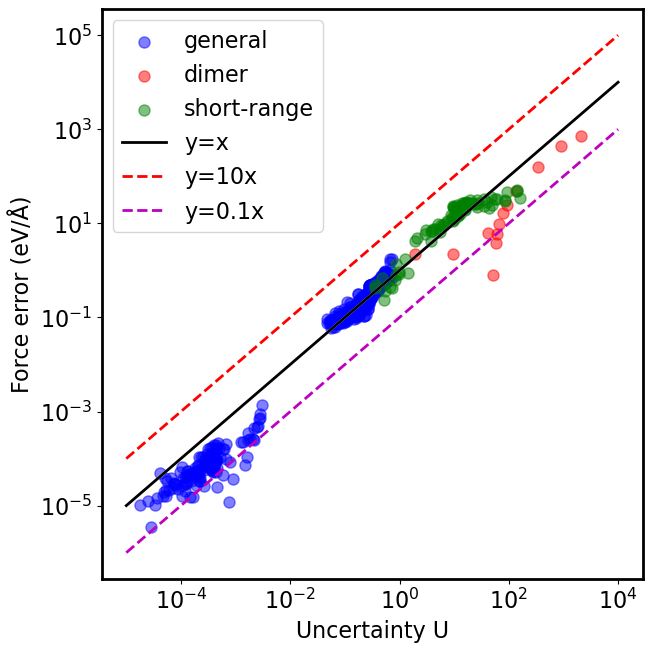

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import LogLocator, NullLocator
plt.rcParams.update({
    'font.size': 16,  # Increase font size
    'axes.labelsize': 16,  # Larger axis labels
    'axes.titlesize': 16,  # Larger titles
    'legend.fontsize': 14,  # Larger legend
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'lines.linewidth': 2,  # Thicker lines
    'lines.markersize': 8,  # Larger markers
})

plt.figure(figsize=(6.41, 6.41), constrained_layout=True)
X = UQ["Uncertainty U"]
Y = UQ["Force_error_max"]

groups = {
    'general': (0, 1025, 'blue'),
    'dimer': (1026, 1038, 'red'),
    'short-range': (1039, 1128, 'green')
}

pe_style = [pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]
# 绘制散点图
for group, (start, end, color) in groups.items():
    mask = (UQ.index >= start) & (UQ.index <= end)
    plt.scatter(X[mask], Y[mask], c=color, label=group, alpha = 0.5)
x_line = np.logspace(-5, 4, 100)  # From 0.001 to 100
plt.plot(x_line, x_line, 'k-', label='y=x',path_effects=pe_style)  # Y=X
plt.plot(x_line, 10*x_line, 'r--', label='y=10x')  # Y=10X
plt.plot(x_line, 0.1*x_line, 'm--', label='y=0.1x')  # Y=0.1X
ax = plt.gca()

ax.xaxis.set_minor_locator(NullLocator())  # 禁用 X 轴小刻度
ax.yaxis.set_minor_locator(NullLocator())  # 禁用 Y 轴小刻度
for spine in ax.spines.values():
    spine.set_linewidth(2)

# 添加标题和标签
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Uncertainty U', fontsize=16)
plt.ylabel('Force error (eV/Å)', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
# plt.savefig('W_best_UQ_error.svg', format='svg', dpi=200)
plt.show()

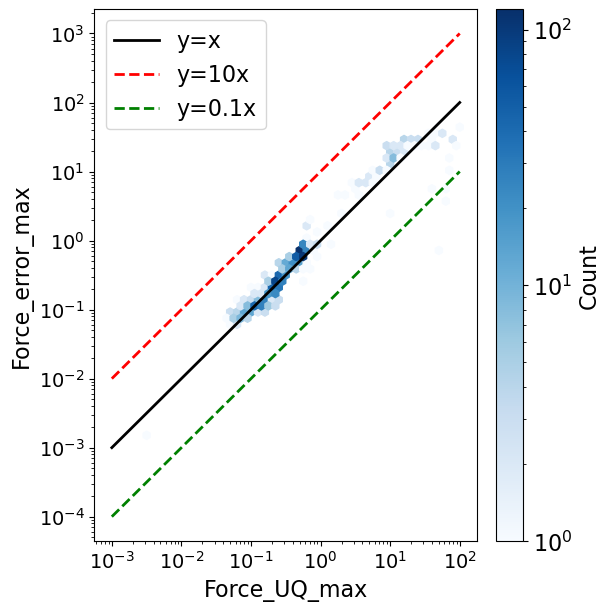

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 6), constrained_layout=True)
X = UQ["Uncertainty U"]
Y = UQ["Force_error_max"]

# 绘制六边形密度图
plt.hexbin(X, Y, gridsize=50, cmap='Blues', xscale='log', yscale='log',
                extent=[-3, 2, -3, 2], mincnt=1, norm=LogNorm(vmin=1))

# 添加 y=x, y=10x, y=0.1x 线
x_line = np.logspace(-3, 2, 100)  # From 0.001 to 100
plt.plot(x_line, x_line, 'k-', label='y=x')  # Y=X
plt.plot(x_line, 10*x_line, 'r--', label='y=10x')  # Y=10X
plt.plot(x_line, 0.1*x_line, 'g--', label='y=0.1x')  # Y=0.1X

# 添加颜色条
plt.colorbar(label='Count')

# 添加标题和标签
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Force_UQ_max', fontsize=16)
plt.ylabel('Force_error_max', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=16)

# 保存图像（可选）
# plt.savefig('E_UQ_F_UQ_hexbin.svg', format='svg', bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Conf. need DFT calculation')

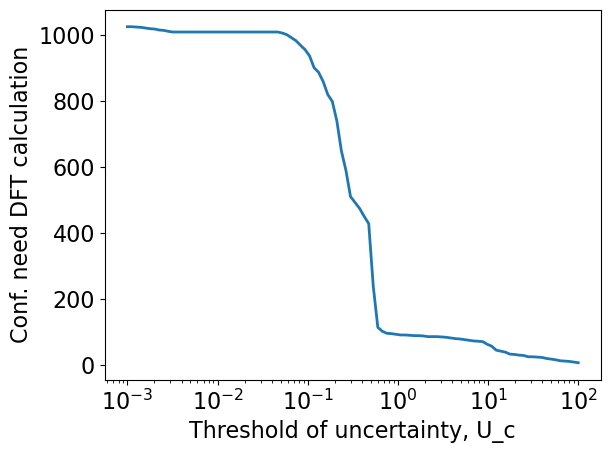

In [14]:
UQ_Number = []
for i in np.logspace(-3, 2, 100):
    indices = UQ["Uncertainty U"] > i
    UQ_Number.append([i, np.sum(indices)])
UQ_Number = np.asarray(UQ_Number)
plt.plot(UQ_Number[:,0],UQ_Number[:,1])
plt.xscale('log')
plt.xlabel('Threshold of uncertainty, U_c', fontsize=16)
plt.ylabel('Conf. need DFT calculation', fontsize=16)

In [16]:
# here  is the DFT fraction in the mixed dataset used for ACE training
Total_LAE = sum(UQ["N_atoms"])
UQ_Number = [0,0.1,0.5,1,10,1000000]
for i in UQ_Number:
    indices = UQ["Uncertainty U"] < i
    N_atoms_frac = (Total_LAE - sum(UQ.loc[indices,"N_atoms"]))/Total_LAE
    print("For U_c = "+str(i)+", the fraction of DFT data is " + str(N_atoms_frac))

For U_c = 0, the fraction of DFT data is 1.0
For U_c = 0.1, the fraction of DFT data is 0.9509667813524879
For U_c = 0.5, the fraction of DFT data is 0.39364399106657816
For U_c = 1, the fraction of DFT data is 0.04274561880042655
For U_c = 10, the fraction of DFT data is 0.027534657250357135
For U_c = 1000000, the fraction of DFT data is 0.0


In [30]:
# #################
# # This section is to replace energy (and force)  with best value of UMLIPs for high-certainty configurations
# #################
# Copy dataframe
List_of_name = {0:"0",0.1:"0.1",0.5:"0.5",1.0:"1",10:"10",1000000:"Inf"}
for i in UQ_Number:
    df_mix = df_dft.copy()

    # Select indices of Conf. with UQ < U_c
    indices = UQ["Uncertainty U"] < i
    print("Num of DFT configurations for U_c = "+str(i) + " is: ",np.sum(indices))

    # Replace values for selected indices
    df_mix.loc[indices, "energy_peratom"] = df_umlip_2.loc[indices, "energy_corrected"] # eqV2_31_OAM for energy
    df_mix.loc[indices, "forces"] = df_umlip_10.loc[indices, "forces"] # eqV2_31_omat for force
    df_mix["energy"] = df_mix.apply(lambda row: row["energy_peratom"] * 
                                                row["ase_atoms"].get_global_number_of_atoms(), axis=1)
    df_mix["energy_corrected"] = df_mix.apply(lambda row: row["energy_peratom"] * 
                                                row["ase_atoms"].get_global_number_of_atoms(), axis=1)
    
    Energy_rmse_mixed = np.sqrt(np.mean((df_mix["energy_peratom"] - df_dft["energy_peratom"])**2))
    print(f"Energy_RMSE for U_c = {i} is: {Energy_rmse_mixed:.5f} eV/atom")

    Force_mixed = np.vstack(df_mix["forces"])
    Force_dft = np.vstack(df_dft["forces"])
    Force_rmse_mixed = np.sqrt(np.mean((Force_dft - Force_mixed)**2))
    print(f"Force_RMSE for U_c = {i} is: {Force_rmse_mixed:.5f} eV/angstrom")
    
    df_mix.to_pickle(f'./UQ_{List_of_name[i]}.pckl.gzip', compression='gzip', protocol=4)
    print("Mixed dataset with U_c = " + str(i) +" has been written into pckl file.")
    print("=========================================================")

Num of DFT configurations for U_c = 0 is:  0
Energy_RMSE for U_c = 0 is: 0.00000 eV/atom
Force_RMSE for U_c = 0 is: 0.00000 eV/angstrom
Mixed dataset with U_c = 0 has been written into pckl file.
Num of DFT configurations for U_c = 0.1 is:  182
Energy_RMSE for U_c = 0.1 is: 0.00255 eV/atom
Force_RMSE for U_c = 0.1 is: 0.00480 eV/angstrom
Mixed dataset with U_c = 0.1 has been written into pckl file.
Num of DFT configurations for U_c = 0.5 is:  767
Energy_RMSE for U_c = 0.5 is: 0.00550 eV/atom
Force_RMSE for U_c = 0.5 is: 0.04624 eV/angstrom
Mixed dataset with U_c = 0.5 has been written into pckl file.
Num of DFT configurations for U_c = 1 is:  1038
Energy_RMSE for U_c = 1 is: 0.00584 eV/atom
Force_RMSE for U_c = 1 is: 0.08420 eV/angstrom
Mixed dataset with U_c = 1 has been written into pckl file.
Num of DFT configurations for U_c = 10 is:  1068
Energy_RMSE for U_c = 10 is: 0.09254 eV/atom
Force_RMSE for U_c = 10 is: 0.24451 eV/angstrom
Mixed dataset with U_c = 10 has been written into p